# Project 5 - Social Recommendation Systems (CiaoDVD Dataset)
### Aim:
The aim of this project is to build a tool that implements and compares different types of recommendation algorithms on a real-world dataset. The tool should be able to: 
* Load the dataset 
* Run different recommendation algorithms on the dataset 
* Compare and discuss the results, parameter sensitivity

In [1]:
from support import data_loading_analysis as dla
from memory_based_cf import MeB
from support import evaluation_metrics as em

import time
import logging
import warnings
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell

# Used to get multiple outputs per cell
InteractiveShell.ast_node_interactivity = "all"

warnings.filterwarnings("ignore")  # ignore warnings in logs

logging.basicConfig(format='%(asctime)s - %(message)s',
                    level=logging.INFO)  # Logging configuration

### Tasks: 1. Load the dataset
- Load the CiaoDVD dataset from https://www.librec.net/datasets.html 
- Explore the properties of the graph

In [2]:
path = 'Ciao-DVD-Datasets/movie-ratings.txt'
data_set = dla.load_dataset(path)
#dataset information
dla.get_information(data_set)

Users: 17615
Movies: 16121
Categories: 17
Ratings count: 72665
Density: 0.000256
Sparsity: 0.999744



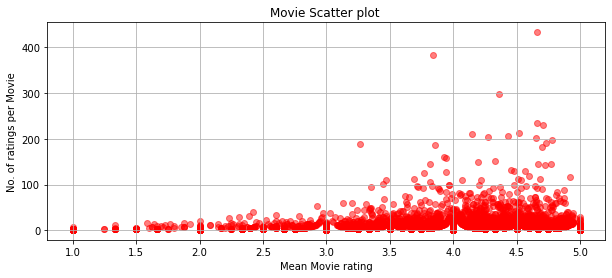

In [3]:
ratings = dla.ratings_analysis(data_set, True)

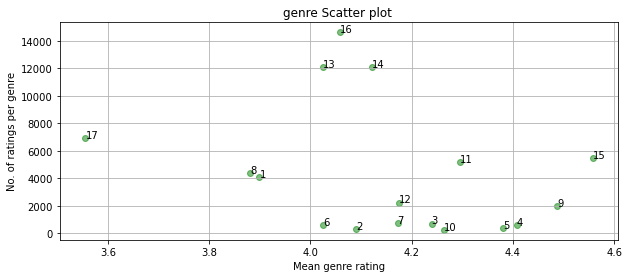

In [4]:
genres = dla.genre_analysis(data_set, True)

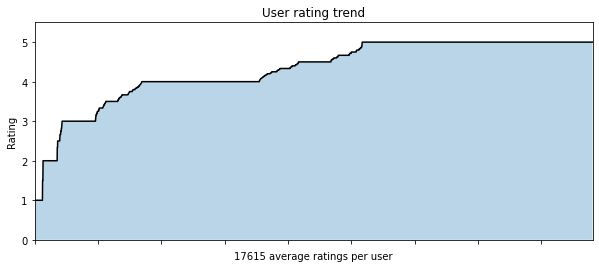

In [5]:
users_avg = dla.user_analysis(data_set, True)

### Tasks: 2. Implementation
Dataset pre-processing

In [6]:
# User and Movie treshold to be considered as relevant for dataset (this helps to reduce the dataset size)
p_user = 1 # threshold to consider a user relevant
p_movie = 1 # threshold to consider a movie popular
p_rnd = 1 # percentage of data to prune 
how = 'r' # Prune by user 'u', by movie 'm' or randomly 'r'

# Here It is got the pruned dataset acording previous parameters
start = time.time()
p_data_set = dla.prune_dataset(data_set, users_avg, ratings, p_user, p_movie, p_rnd, how)
logging.info("Process done in: {0:.5f} seconds".format(time.time() - start))
p_data_set.shape
# New dataset information
dla.get_information(p_data_set)

2020-05-14 17:45:32,370 - Process done in: 0.07354 seconds
Pruned by Movie


(6912, 4)

Users: 4154
Movies: 42
Categories: 9
Ratings count: 6912
Density: 0.039618
Sparsity: 0.960382



In [7]:
# Rating matrix (only the user ratings per movie)
start = time.time()
R_matrix = p_data_set.pivot_table(index = 'userId', columns ='movieId', values = 'movieRating')
logging.info("Process done in: {0:.5f} seconds".format(time.time() - start))
index_names = R_matrix.index # Save the users Id
columns_names = R_matrix.columns # Save the movies Id
R_matrix = R_matrix.values # Get only the ratings
R_matrix.shape

2020-05-14 17:45:32,473 - Process done in: 0.05940 seconds


(4154, 42)

In [8]:
# Split Rating matrix into training and testing datasets
start = time.time()
train,test = dla.split_train_test_custom(R_matrix,0.2)
logging.info("Process done in: {0:.5f} seconds".format(time.time() - start))

2020-05-14 17:45:32,539 - Process done in: 0.01482 seconds


### Task 2.1 User based Collaborative Filtering Recommender with pearson correlation coefficient.

In [9]:
# Memory Based RS instance.
bounds = (1, 5)  # max and min boundaries
u2u_pc = MeB(train, index_names, columns_names, bounds)
# user average list
start = time.time()
u2u_pc.get_user_avgs()
logging.info("Process done in: {0:.5f} seconds".format(time.time() - start))

2020-05-14 17:45:32,574 - Process done in: 0.00468 seconds


In [10]:
# Pearson Correlation Coeficient
start = time.time()
u2u_pc.pearson_correlation()
logging.info("Process done in: {0:.5f} seconds".format(time.time() - start))

2020-05-14 17:45:33,309 - Process done in: 0.70405 seconds
(4154, 4154)


In [11]:
# Neighborhood selection based on k size
def get_neighborhood(k_size):
    k = k_size  # Define the k neighbors size
    start = time.time()
    u2u_pc.neighborhood(k)  
    end = time.time() - start
    logging.info(f"Neighborhood for k-size= {k} done in: {end:.5f} seconds")
    return end

In [12]:
# Prediction Computing: Mean-Centering normalization
def get_prediction():
    start = time.time()
    prediction = u2u_pc.predict()
    end = time.time() - start
    logging.info(f"Prediction for k-size= {k} done in: {end:.5f} seconds")
    return prediction, end

In [13]:
logging.info('Metrics evaluation')
def get_metrics(prediction):
    start = time.time()
    rmse = em.RMSE(test,prediction)
    mae = em.MAE(test,prediction)
    print('RMSE: ',rmse)
    print('MAE: ',mae)
    end = time.time() - start
    logging.info(f"Metrics for k-size= {k} size done in: {end:.5f} seconds")
    return rmse, mae

2020-05-14 17:45:33,417 - Metrics evaluation


In [14]:
# Implementation of loop for get the results for different k-size values
n_times = {}
p_times = {}
metrics = {}
for k in range(5, 50, 10):
   n_time = get_neighborhood(k)
   n_times[k] = n_time
   prediction, p_time = get_prediction()
   p_times[k] = p_time
   rmse, mae = get_metrics(prediction)
   metrics[k] = (rmse,mae)

2020-05-14 17:45:41,944 - Neighborhood for k-size= 5 done in: 8.49393 seconds
2020-05-14 17:45:52,755 - Prediction for k-size= 5 done in: 10.80979 seconds
2020-05-14 17:45:52,763 - Metrics for k-size= 5 size done in: 0.00700 seconds
RMSE:  2.37477845723579
MAE:  1.9019076731938191
2020-05-14 17:46:02,331 - Neighborhood for k-size= 15 done in: 9.56691 seconds
2020-05-14 17:46:14,669 - Prediction for k-size= 15 done in: 12.33483 seconds
2020-05-14 17:46:14,691 - Metrics for k-size= 15 size done in: 0.01811 seconds
RMSE:  1.651041245198745
MAE:  1.2301520629942573
2020-05-14 17:46:25,344 - Neighborhood for k-size= 25 done in: 10.65087 seconds
2020-05-14 17:46:34,715 - Prediction for k-size= 25 done in: 9.36930 seconds
2020-05-14 17:46:34,724 - Metrics for k-size= 25 size done in: 0.00702 seconds
RMSE:  1.5144049509581996
MAE:  1.1233902385702832
2020-05-14 17:46:41,393 - Neighborhood for k-size= 35 done in: 6.66779 seconds
2020-05-14 17:46:51,893 - Prediction for k-size= 35 done in: 10.49

In [15]:
# pd.DataFrame(metrics, index=['rmse','mae']).T.to_csv('results/metrics.csv',float_format='%.5f')
# pd.DataFrame(n_times, index=['time']).T.to_csv('results/neighborhood_time.csv',float_format='%.2f')
# pd.DataFrame(p_times, index=['time']).T.to_csv('results/prediction_time.csv',float_format='%.2f')